# Data Loader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import SVHN

In [2]:
batch_size=16

# Define transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training dataset
trainset = SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Download and load the test dataset
testset = SVHN(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in SVHN dataset
classes = list(range(10))

100%|██████████| 182040794/182040794 [00:06<00:00, 28327945.96it/s]


100%|██████████| 64275384/64275384 [00:04<00:00, 15509217.91it/s]


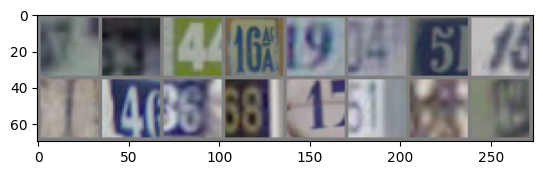

    7     3     4     6     9     4     5     1     1     4     6     8     1     1     4     4


In [3]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Model

In [4]:
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.init as init

In [5]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        
        #Weight initialization
        init.xavier_normal_(self.conv.weight)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

In [6]:
class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            
        # Weight initialization
        init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


In [7]:
class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )
            
        # Weight initialization
        init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [8]:
class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        
        #self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)
        
        # Weight initialization
        init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        init.xavier_normal_(self.linear.weight)
        

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

In [9]:
class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        #self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=1)
        

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)       #reshaped to have dimensions (batch_size, 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        
        #x = x.view(x.size(0), 3, 64, 64)
        x = x.view(x.size(0), 3, 32, 32)

        return x

In [10]:
class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def forward(self, x):
        mean, logvar = self.encoder(x)
        #z = self.reparameterize(mean, logvar)

        # sample z from q
        std = torch.exp(logvar / 2)
        q = torch.distributions.Normal(mean, std)
        z = q.rsample()
        
        x_recon = self.decoder(z)   
        
        return x_recon, mean, logvar, z
    
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def loss(self, x_hat, x, z, mu, logvar):
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        std = torch.exp(logvar / 2)
        kl = self.kl_divergence(z, mu, std)

        # elbo
        #print(kl,recon_loss)
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        return elbo
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [11]:
# Get a batch of images and labels
dataiter = iter(trainloader)
images, _ = next(dataiter)

# Forward pass through VAE model to obtain reconstructed images, mean, and log variance
vae_model_ins = VAE(z_dim=32)
recon_images, mu, logvar, z = vae_model_ins(images)

# Compute VAE loss
loss = vae_model_ins.loss(recon_images, images, z, mu, logvar)
# Print the loss

print("VAE Loss:", loss.item())

VAE Loss: 3813.23779296875


# Training

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
from torch.optim import Adam,SGD
from torch.optim.lr_scheduler import StepLR,ExponentialLR


vae_model = VAE(z_dim=32)
vae_model.to(device)

optimizer = Adam(vae_model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.99)

In [14]:
from tqdm.auto import tqdm

loss_values=[]

for epoch in range(1): 
    vae_model.train()
    running_loss = 0.0
    epoch_loss=0.0
    for i, data in tqdm(enumerate(trainloader, 0), desc="Training Progress"):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_hat, mu, logvar,z = vae_model(inputs)
        loss = vae_model.loss(x_hat, inputs, z, mu, logvar)
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_loss += loss.item() 
        epoch_loss += loss.item() 

        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
    epoch_loss /= len(trainloader) * batch_size
    loss_values.append(epoch_loss) 
    print(f'{epoch + 1} loss: {epoch_loss:.3f}')
    scheduler.step()
print('Training Finished... ')

Training Progress: 0it [00:00, ?it/s]

[1,  1000] loss: 8491.918
[1,  2000] loss: 1631.728
[1,  3000] loss: 1616.757
[1,  4000] loss: 1623.955
1 loss: 195.266
Training Finished... 


In [15]:
PATH = './cifar_net.pth'
torch.save(vae_model.state_dict(), PATH)

In [16]:
vae_model1 = VAE(z_dim=32)
vae_model1.load_state_dict(torch.load(PATH))

<All keys matched successfully>

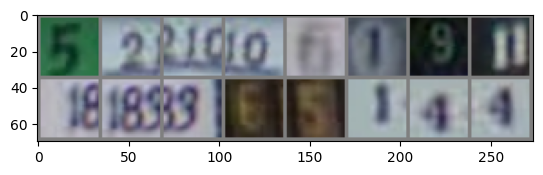

In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

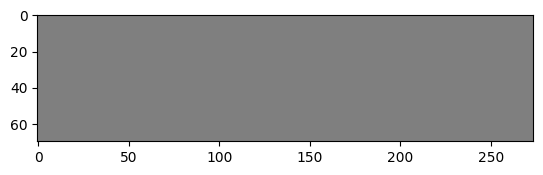

In [18]:
outputs, _, _, _ = vae_model1(images)
imshow(torchvision.utils.make_grid(outputs))

In [19]:
loss_values

[195.26572517766576]

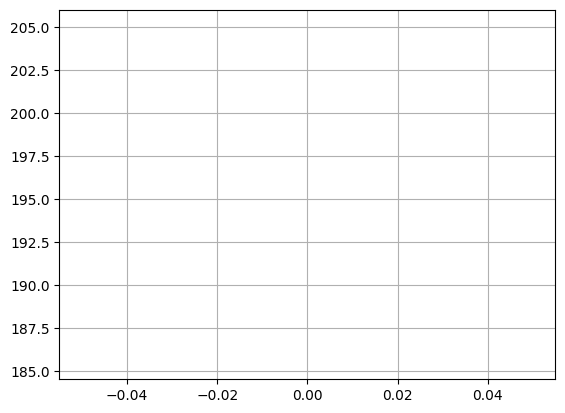

In [20]:
plt.plot(loss_values)
plt.grid()